In [1]:
%matplotlib inline
import torch
import numpy as np
import pandas as pd
import abel
import os
from torchvision.transforms import ToTensor
from torch.nn import functional as F
from matplotlib import pyplot as plt
from scipy.stats import entropy
from skimage.util import random_noise
from skimage.metrics import peak_signal_noise_ratio
from sklearn.neighbors import KernelDensity
from ruamel.yaml import YAML

from dii.models.base import valid_models
from dii.visualization.visualize import radial_profile, half_half_image
# from dii.pipeline.datautils import get_benchmark_imageset
from dii.pipeline.make_dataset import generate_image
from dii.pipeline.transforms import Normalize

plt.style.use("publication")

/home/kelvin/anaconda3/envs/ion-image/lib/python3.7/site-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Checkpoint directory /home/kelvin/Dropbox (MIT)/Projects/deep-ion-image/notebooks/reports exists and is not empty.
  warnings.warn(*args, **kwargs)


In [2]:
# Parameter cell; do not edit!
model_kwargs = {
    "in_channels": 1,
    "out_channels": 1,
    "latent_dim": 64,
    "activation": "silu"
}
image_index = 50
models_path = "../../models/"
benchmark_path = "../../data/processed"
n_images = 128
model_name = "vae"
probabilistic = True
img_center = (64, 64)
output_root = "outputs/"
seed = 42069

In [3]:
# Parameters
model_kwargs = {
    "in_channels": 1,
    "out_channels": 1,
    "latent_dim": 64,
    "activation": "silu",
}
probabilistic = True
model_name = "vaegan"


In [4]:
# output path is where model specific results go
# agg path is a YAML with the combined statistics for summarizing across models
output_path = f"{output_root}{model_name}/"

# make the images generated semi-deterministic
rng = np.random.default_rng(seed)

In [5]:
try:
    os.mkdir(output_path)
except:
    pass

## Load in the model

In [6]:
# figure out what model we are using with the mapping
model = valid_models.get(model_name, None)

if not model:
    raise KeyError(f"{model_name} is not a valid model in the `dii` codebase! Try again!")

In [7]:
model_obj = model(**model_kwargs)
model_obj.load_state_dict(torch.load(f"{models_path}{model_name}.pt"))

# make sure we have the correct behavior for everything
model_obj.eval();

In [8]:
def generate_multiple_rings(n_rings: int, img_size: int = 128):
    """
    Generate an image with `n_rings` concentric, linearly spaced, isotropic rings.
    """
    center = img_size // 2
    # same as used for the image generation pipeline
    min_size, max_size = center * 0.1, center * 0.8
    # generate a number of concentric rings
    centers = np.linspace(min_size, max_size, n_rings)
    central_image = np.zeros((img_size, img_size), dtype=np.float32)
    projection = np.zeros_like(central_image)
    for value in centers:
        temp_central, temp_projection = generate_image(value, 1., 0., img_size)
        central_image += (temp_central / temp_central.max())
        projection += (temp_projection / temp_projection.max())
    central_image /= central_image.max()
    projection /= projection.max()
    return (central_image, projection)


def add_noise(image: np.ndarray, rng: "Generator", var: float):
    """
    Adds an amount of Gaussian and Poisson noise to the image.
    """
    gaussian_noise = rng.normal(0., var, size=image.shape)
    poisson_image = random_noise(image, "poisson", clip=True)
    result = (gaussian_noise + poisson_image).astype(np.float32)
    normalize = Normalize()
    result = normalize(result)
    image = normalize(image)
    snr = peak_signal_noise_ratio(image, result)
    return (result, snr)

## Multiple isotropic rings with decreasing SNR

In [9]:
central, projection = generate_multiple_rings(3, img_center[0] * 2)

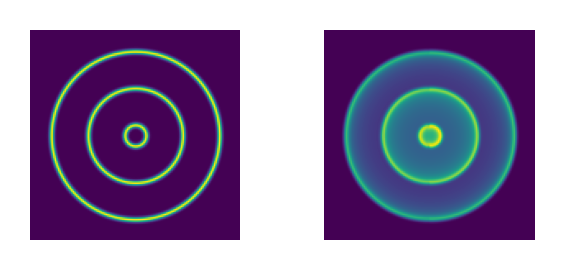

In [10]:
fig, axarray = plt.subplots(1, 2, figsize=(2.5, 1))

for ax, image, title in zip(axarray, [central, projection], ["Target", "Projection"]):
    ax.imshow(image)
    ax.set(yticks=[], xticks=[])
    for _, spine in ax.spines.items():
        spine.set_visible(False)
fig.tight_layout()

In [11]:
noisy_images = list()
snr_list = list()
for var in np.logspace(-3., 0., 6):
    noisy, snr = add_noise(projection, rng, var)
    noisy_images.append(noisy[np.newaxis,:,:])
    snr_list.append(snr)
noisy_images = np.vstack(noisy_images)

### Show what the images look like as a function of SNR

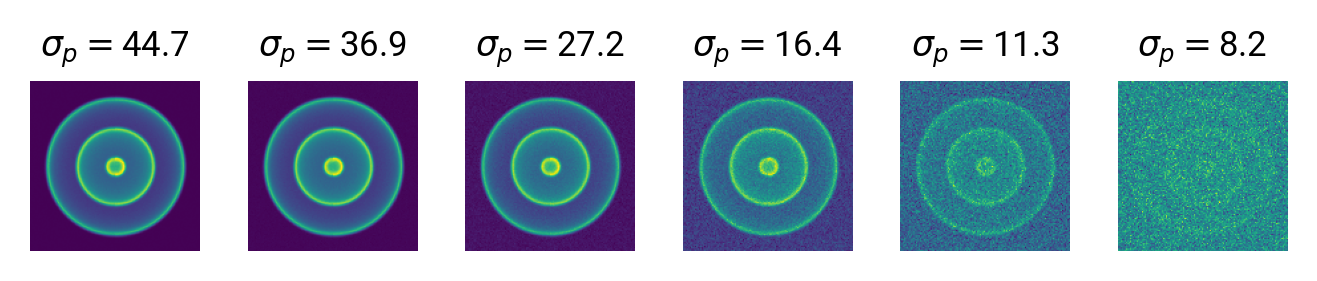

In [12]:
fig, axarray = plt.subplots(1, len(noisy_images), figsize=(4.5, 1))

for ax, image, snr in zip(axarray, noisy_images, snr_list):
    ax.imshow(image)
    ax.set(yticks=[], xticks=[], title=f"$\sigma_{{p}}=${snr:.1f}")
    for _, spine in ax.spines.items():
        spine.set_visible(False)
fig.tight_layout()

## Run predictions for each noisy image and collect statistics

In the somewhat complicated looking code below, we are doing three things:

1. Conditional sampling of reconstructed images
2. Calculating the log likelihood of each image
3. Calculating the "expected"/mean image from the likelihood weighting

In [13]:
tensor_conversion = ToTensor()

In [14]:
predictions = list()
for image in noisy_images:
    input_image = tensor_conversion(image)
    predictions.append(model_obj.predict(input_image))

In [15]:
ll_counts = list()
combined_images = list()
mean_images = list()
# more of a grid for evaluating the KDE likelihood
bins = np.linspace(-100., 0., 100)
for image in noisy_images:
    x = tensor_conversion(image)
    # transform into a batch
    X = x.repeat(400, 1, 1, 1)
    with torch.no_grad():
        z, Y, p, q = model_obj._run_step(X)
        # get the summed log likelihood of each image; i.e. multiplicative likelihoods
        probs = q.log_prob(z).sum(-1)
        # get the normalizing factor for each image
        norm = probs.exp().sum()
        norm_probs = probs.exp().div(norm)
        # each image is weighted by likelihood
        expected_image = (norm_probs.view(-1, 1, 1, 1) * Y).sum(0).numpy()
        # use kernel density estimation to do get image log likelihood distributions
        kde = KernelDensity().fit(probs.numpy()[:,None])
        kde_y = np.exp(kde.score_samples(bins[:,None]))
        # normalize the KDE likelihoods
        kde_y /= kde_y.sum()
        ll_counts.append(kde_y)
        # add the mean image to the stack
        combined_images.append(expected_image.squeeze())
        mean_images.append(Y.mean(dim=(0, 1)))
ll_counts = np.vstack(ll_counts)

### Plotting model certainty as a function of SNR

The desired behavior is model becomes less certain as we use images with progressively lower SNR. The idea is that the distribution of log likelihoods should spread out, and perhaps encompass more images that are low likelihood.

In [16]:
colors = plt.cm.get_cmap("viridis")(np.linspace(0., 1., len(noisy_images)))

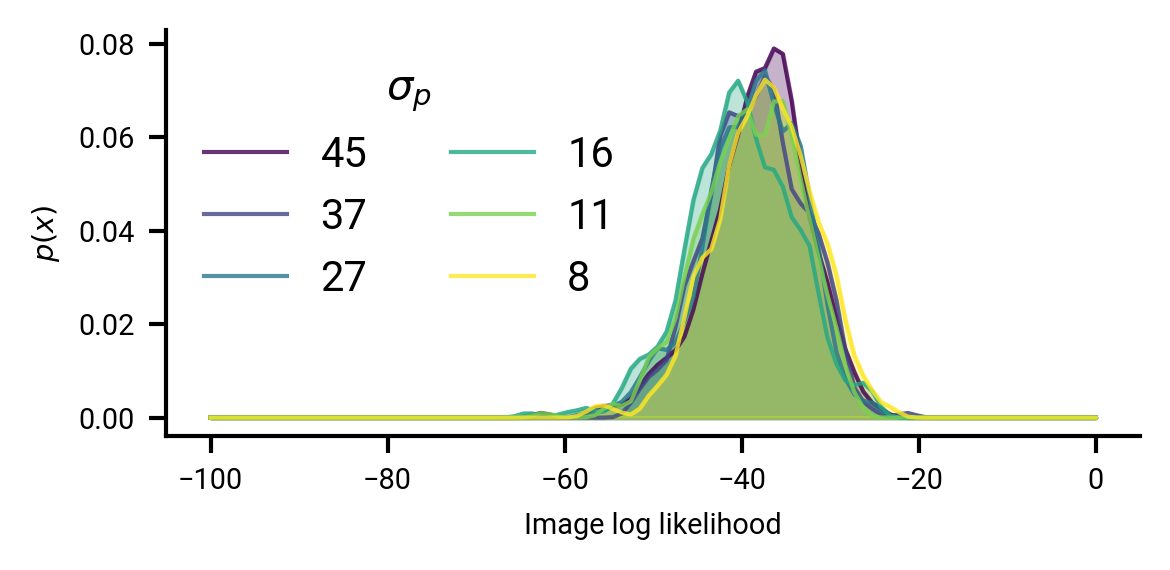

In [17]:
fig, ax = plt.subplots(figsize=(4, 2.))

for color, counts, snr in zip(colors, ll_counts, snr_list):
    ax.plot(bins, counts, color=color, alpha=0.8, label=f"{snr:.0f}")
    ax.fill_between(bins, counts, color=color, alpha=0.3)
ax.set(xlabel="Image log likelihood", ylabel="$p(x)$")
ax.legend(ncol=2, title="$\sigma_p$")
fig.savefig(f"{output_path}likelihoods_snr.png", dpi=600)

### Side-by-side comparison of the input and reconstruction at each SNR

This shows how well the model fares with low SNR images

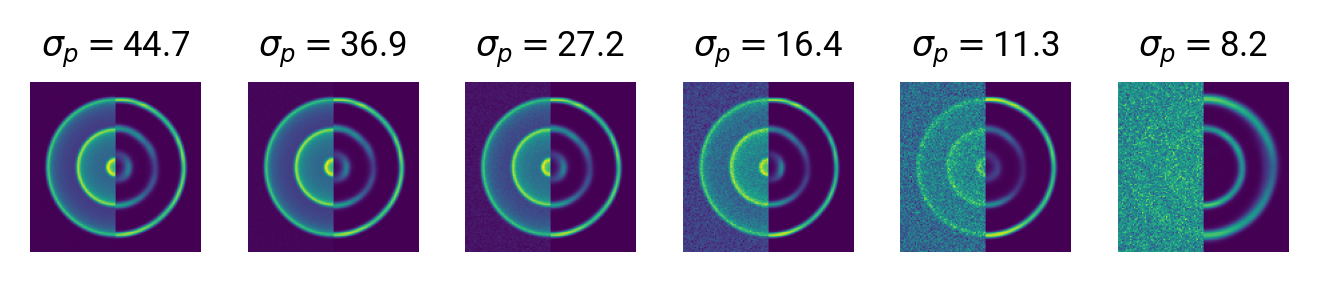

In [18]:
fig, axarray = plt.subplots(1, len(noisy_images), figsize=(4.5, 1))

for ax, input_img, pred_img, snr in zip(axarray, noisy_images, combined_images, snr_list):
    temp = half_half_image(input_img, pred_img)
    ax.imshow(temp)
    ax.set(xticks=[], yticks=[], title=f"$\sigma_p=${snr:.1f}")
    for _, spine in ax.spines.items():
        spine.set_visible(False)
fig.savefig(f"{output_path}lowsnr_reconstruction.png", dpi=600)

## Increasing number of rings

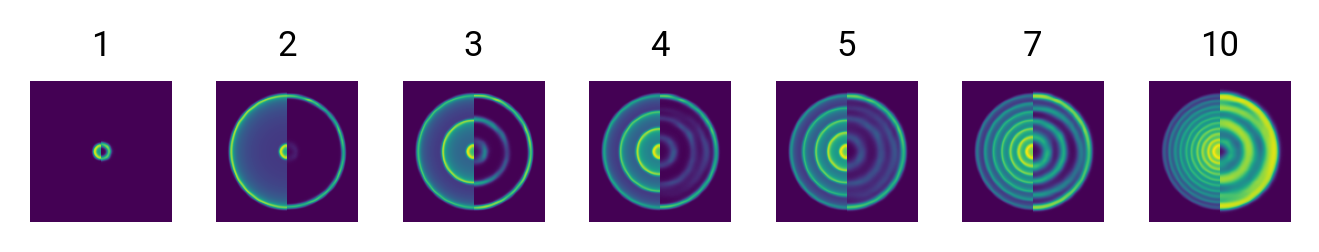

In [19]:
ring_list = [1, 2, 3, 4, 5, 7, 10]
fig, axarray = plt.subplots(1, len(ring_list), figsize=(4.5, 1))
for ax, n_rings in zip(axarray, ring_list):
    central, projection = generate_multiple_rings(n_rings, img_center[0] * 2)
    pred_image = model_obj.predict(tensor_conversion(projection)).mean(0).squeeze()
    display_image = half_half_image(projection, pred_image)
    ax.imshow(display_image)
    ax.set(xticks=[], yticks=[], title=n_rings)
    for spine in ax.spines.values():
        spine.set_visible(False)
fig.tight_layout()
fig.savefig(f"{output_path}spam_rings.png", dpi=600)